In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
df = pd.read_parquet("processed_data/final_with_anomalies.parquet")
store_features = pd.read_parquet("processed_data/store_features.parquet")
store_features.head()

,Store,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size,Cluster_KMeans3,Cluster_KMeans5,Cluster_pt_KMeans6,HC_Cluster5,Cluster_pt_KMeans2,HC_Cluster3
0,1,21710.543621,27748.945511,0.005136,0.051738,0.000976,0.356989,0.070578,151315,0,1,4,2,1,1
1,2,26898.070031,33077.612059,0.012600,0.061340,0.000195,0.357785,0.070522,202307,0,0,4,2,1,1
2,3,6373.033983,14251.034807,0.006354,0.018814,0.001439,0.359119,0.070053,37392,1,3,2,5,0,3
3,4,29161.210415,34583.677814,0.003083,0.080997,0.001266,0.357866,0.070775,205863,0,0,4,2,1,1
4,5,5053.415813,8068.221050,0.005480,0.006890,0.000889,0.358151,0.071119,34875,1,3,3,3,0,2


In the segmentation notebook 1 , the best clustering for Store behaviour was achieved by the Cluster_pt_KMeans6.We will use it here.

In [3]:
store_cluster_map = store_features.loc[:,["Store" , "Cluster_pt_KMeans6"]]
# rename the cluster column to Cluster
store_cluster_map = store_cluster_map.rename(columns={"Cluster_pt_KMeans6": "Cluster"})


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Has_Markdown,Week,Month,Year,Rolling_Mean_4,Rolling_Std_4,Z_Score,Pct_Deviation,Lag_1,Type_B,Type_C,IF_Anomaly,LOF_Anomaly,High_Confidence_Anomaly
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,0,5,2,2010,24924.500000,0.000000,NaN,0.000000,24924.50,False,False,0,0,0
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315,0,6,2,2010,35481.995000,14930.552614,0.707107,0.297545,24924.50,False,False,1,0,0
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315,0,7,2,2010,37519.846667,11131.900957,0.366128,0.108628,46039.49,False,False,0,0,0
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,151315,0,8,2,2010,32990.770000,12832.106391,-1.058846,-0.411849,41595.55,False,False,0,0,0
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,151315,0,9,3,2010,32216.620000,13554.047185,-0.766466,-0.322465,19403.54,False,False,0,0,0


In [6]:
df = df.merge(store_cluster_map, on="Store", how="left")
df.shape

(421570, 30)

In [7]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Has_Markdown', 'Week',
       'Month', 'Year', 'Rolling_Mean_4', 'Rolling_Std_4', 'Z_Score',
       'Pct_Deviation', 'Lag_1', 'Type_B', 'Type_C', 'IF_Anomaly',
       'LOF_Anomaly', 'High_Confidence_Anomaly', 'Cluster'],
      dtype='str')

In [8]:
# removing the Leakage feautures (those that were computed using the Current Weekly Sales)

leakage_features = ["Z_Score","IF_Anomaly","LOF_Anomaly","High_Confidence_Anomaly","Pct_Deviation"]

# remove the leakage features from the dataframe
df = df.drop(columns=leakage_features)

In [9]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Has_Markdown', 'Week',
       'Month', 'Year', 'Rolling_Mean_4', 'Rolling_Std_4', 'Lag_1', 'Type_B',
       'Type_C', 'Cluster'],
      dtype='str')

In [10]:
df = df.sort_values(["Store","Dept","Date"])

# recomputing the rolling_mean_4 with shift(1) to avoid data leakage

df["Rolling_Mean_4"] = (
    df.groupby(["Store", "Dept"])["Weekly_Sales"]
      .shift(1)
      .rolling(4, min_periods=1)
      .mean()
)

# recomputing the rolling_std_4 with shift(1) to avoid data leakage

df["Rolling_Std_4"] = (
    df.groupby(["Store", "Dept"])["Weekly_Sales"]
      .shift(1)
      .rolling(4, min_periods=1)
      .std()
)

In [11]:
df[["Store","Dept","Date","Weekly_Sales","Rolling_Mean_4"]].head(10)


,Store,Dept,Date,Weekly_Sales,Rolling_Mean_4
0,1,1,2010-02-05,24924.50,NaN
1,1,1,2010-02-12,46039.49,24924.500000
2,1,1,2010-02-19,41595.55,35481.995000
3,1,1,2010-02-26,19403.54,37519.846667
4,1,1,2010-03-05,21827.90,32990.770000
5,1,1,2010-03-12,21043.39,32216.620000
6,1,1,2010-03-19,22136.64,25967.595000
7,1,1,2010-03-26,26229.21,21102.867500
8,1,1,2010-04-02,57258.43,22809.285000
9,1,1,2010-04-09,42960.91,31666.917500


In [12]:
df.isna().sum()

Store             0
Dept              0
Date              0
Weekly_Sales      0
IsHoliday         0
Temperature       0
Fuel_Price        0
MarkDown1         0
MarkDown2         0
MarkDown3         0
MarkDown4         0
MarkDown5         0
CPI               0
Unemployment      0
Size              0
Has_Markdown      0
Week              0
Month             0
Year              0
Rolling_Mean_4    1
Rolling_Std_4     4
Lag_1             0
Type_B            0
Type_C            0
Cluster           0
dtype: int64

In [13]:
df = df.dropna(subset=["Rolling_Mean_4", "Rolling_Std_4"])


In [14]:
df.shape,df.columns

((421566, 25),
 Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
        'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
        'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Has_Markdown', 'Week',
        'Month', 'Year', 'Rolling_Mean_4', 'Rolling_Std_4', 'Lag_1', 'Type_B',
        'Type_C', 'Cluster'],
       dtype='str'))

In [15]:
# we will exclude store (identifier) , dept(identifier) and date (time component),Weekly_sales(target) , Raw Markdown(1-5)(noisy sparse),Type_B,Type_C(because we already have clusters captured ) from the features used for modeling

feature_cols = [
    "Lag_1",
    "Rolling_Mean_4",
    "Rolling_Std_4",
    "IsHoliday",
    "Has_Markdown",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Cluster"
]


For forecasting the future , we must split by time and not randomly

In [16]:
# date sorting
df = df.sort_values("Date")

# Defining Split Date (we will use the last 12 weeks for testing)
last_date = df["Date"].max()
split_date = last_date - pd.Timedelta(weeks=12)

print("Last date:", last_date)
print("Train end date:", split_date)


Last date: 2012-10-26 00:00:00
Train end date: 2012-08-03 00:00:00


In [17]:
# Create Train & Test Sets
train_df = df[df["Date"] <= split_date].copy()
test_df  = df[df["Date"] > split_date].copy()

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

Train shape: (386003, 25)
Test shape : (35563, 25)


In [18]:
target = "Weekly_Sales"
X_train = train_df[feature_cols]
y_train = train_df[target]

X_test  = test_df[feature_cols]
y_test  = test_df[target]


In [19]:
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("Any NaNs in X_train?", X_train.isnull().sum().sum())
print("Any NaNs in X_test?", X_test.isnull().sum().sum())


X_train shape: (386003, 9)
X_test shape : (35563, 9)
Any NaNs in X_train? 0
Any NaNs in X_test? 0


In [20]:
print("Min:", y_test.min())
print("Max:", y_test.max())
print("Mean:", y_test.mean())
print("Std:", y_test.std())


Min: -771.9
Max: 194032.48
Mean: 15588.451227680454
Std: 21907.08836841383


In [21]:
# Rolling_Mean_4 as baseline prediction 

baseline_pred = test_df["Rolling_Mean_4"]
# evaluate baseline
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = root_mean_squared_error(y_test, baseline_pred)

print("Baseline MAE :", baseline_mae)
print("Baseline RMSE:", baseline_rmse)


Baseline MAE : 1580.6364715668892
Baseline RMSE: 3622.040628134711


Train Gradient Boosting Regressor for prediction of Weekly Sales

In [22]:
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train, y_train)


,loss,'squared_error'
,learning_rate,0.05
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


In [23]:
ml_pred = gbr.predict(X_test)
ml_pred[:10]

array([ 9494.64218268, 25443.87787621,  6954.96736263,  5234.59002678,
        4822.89655675, 21121.53161118, 10127.57339719, 61714.08105086,
         273.96159916,  3756.19981698])

In [24]:
# Evaluated the model predictions
ml_mae = mean_absolute_error(y_test, ml_pred)
ml_rmse = root_mean_squared_error(y_test, ml_pred)

print("ML MAE :", ml_mae)
print("ML RMSE:", ml_rmse)


ML MAE : 1445.6838383649863
ML RMSE: 3129.533495941504


In [25]:
from sklearn.metrics import r2_score

baseline_r2 = r2_score(y_test, baseline_pred)
print("Baseline R²:", baseline_r2)


ml_r2 = r2_score(y_test, ml_pred)
print("ML R²:", ml_r2)


Baseline R²: 0.9726630834611532
ML R²: 0.9795919222373768


In [26]:
# feature importances for the gbr model 
feature_importance = pd.Series(
    gbr.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

feature_importance

Lag_1             0.872624
Rolling_Mean_4    0.119442
Rolling_Std_4     0.003028
Fuel_Price        0.001664
IsHoliday         0.001256
CPI               0.001236
Unemployment      0.000420
Cluster           0.000326
Has_Markdown      0.000005
dtype: float64

In [42]:
# Prediction Plot for Store=12 and Dept = 1 

sample = test_df[
    (test_df["Store"]==12) & (test_df["Dept"]==1)
].copy()

sample['Pred'] =gbr.predict(sample[feature_cols])


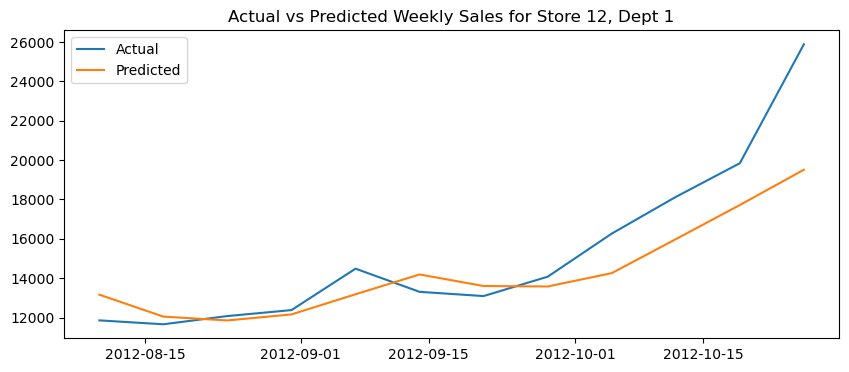

In [44]:
plt.figure(figsize=(10,4))
plt.plot(sample["Date"], sample["Weekly_Sales"], label="Actual")
plt.plot(sample["Date"], sample["Pred"], label="Predicted")
plt.title("Actual vs Predicted Weekly Sales for Store 12, Dept 1")
plt.legend()
plt.show()

In [47]:
# saving the model 
import joblib
import os 
os.makedirs("models", exist_ok=True)
joblib.dump(gbr, "models/gradient_boosting_forecast_model.pkl")

# save feature cols and split_date 

model_info = {
    "feature_cols": feature_cols,
    "split_date": split_date
}
joblib.dump(model_info, "models/model_info.pkl")

['models/model_info.pkl']

📌 Forecasting Results – Final Interpretation

The Gradient Boosting model demonstrated consistent improvement over the rolling mean baseline across all evaluation metrics.

🔹 Performance Summary

The ML model reduced MAE and RMSE compared to the baseline.

R² improved from approximately 0.973 (baseline) to 0.980 (ML model), indicating better variance explanation.

The model successfully captured general sales trends and short-term fluctuations.

🔹 Behavior Around Spikes

From the visual inspection of Store 12, Dept 1:

The model closely tracks the overall upward and downward movement in weekly sales.

Extreme peaks are slightly under-estimated, which is common in tree-based models.

This smoothing behavior suggests the model prioritizes stability over aggressive spike fitting.

🔹 Feature Importance Insights

Feature importance analysis reveals:

Lag_1 is the dominant predictor, highlighting strong short-term autocorrelation in retail sales.

Rolling_Mean_4 provides additional smoothing context.

Macroeconomic indicators and cluster information contribute marginally but provide structural context.

This indicates that retail demand in this dataset is heavily driven by recent historical sales patterns.

🔹 Business Interpretation

A simple rolling average is already a strong forecasting baseline in retail.

However, incorporating lag-based features and contextual indicators yields measurable improvement.

The model is capable of capturing trend and seasonal patterns while maintaining reasonable stability during volatile periods.

🔹 Limitations

Extreme anomaly spikes are partially smoothed rather than perfectly predicted.

The model is global across stores and departments; separate models per cluster may further improve accuracy.

Additional seasonal lags (e.g., 4-week or 52-week) could enhance long-term pattern learning.

🔹 Conclusion

The final forecasting model provides a statistically meaningful improvement over the baseline and demonstrates that machine learning techniques can enhance retail demand forecasting when combined with proper feature engineering and time-aware validation.